In [1]:
# Cell 1
# Import libraries
import pandas as pd
import numpy as np
import nltk
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
# Ensure NLTK resources are available
nltk.download('punkt')
nltk.download('stopwords')


2023-11-15 18:48:50.560510: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/PremGanesh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/PremGanesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Cell 2
# Load your Excel files for training and validation
train_file_path = '/Users/PremGanesh/Developer/AI/CyVidia/Input_Data/Training Dataset.xlsx'
# load the excel file as a dataframe
train_df = pd.read_excel(train_file_path) 
print(train_df.shape) # print the shape of the dataframe
model_name = 'trained_model_rbi_jll_nist_SCF'
output_name = 'rbi_jll_nist_SCF'

(2104, 3)


In [3]:
# Cell 3
# Define a function for text cleaning
def clean_text(text):
    if isinstance(text, float) and np.isnan(text): # check if the text is NaN
        return "" # return empty string
    words = word_tokenize(text) # tokenize the text into words using NLTK library 
    words = [word.lower() for word in words if word.isalnum()] # convert all words to lower case and remove punctuations    
    stop_words = set(stopwords.words('english')) # get the stop words from NLTK library 
    words = [word for word in words if word not in stop_words] # remove stop words from the text
    clean_text = ' '.join(words) # join all words into a sentence
    return clean_text # return the cleaned text


In [4]:
# Cell 4
# Apply text cleaning to 'Requirement Description' column for training and validation data
train_df['Cleaned_Description'] = train_df['Requirement Description'].apply(clean_text)

In [5]:
# Cell 5
# Tokenize and pad sequences for training data
max_words = 10000 # We will only consider the top 1000 words in the dataset i want to use the complete dataset
tokenizer = Tokenizer(num_words=max_words) # Setup tokenizer using keras Tokenizer class 
tokenizer.fit_on_texts(train_df['Cleaned_Description']) # fit tokenizer on training data
X_train = tokenizer.texts_to_sequences(train_df['Cleaned_Description']) # convert text to sequence of tokens
X_train = pad_sequences(X_train, maxlen=100) # pad sequences to make them of equal length
print(X_train.shape) # print shape of training data

(2104, 100)


In [6]:

# Cell 6
# Label encode 'Requirement Area' for training data
area_encoder = LabelEncoder()
train_df['Requirement Area (NIST)'] = train_df['Requirement Area (NIST)'].str.lower()
y_area_train = area_encoder.fit_transform(train_df['Requirement Area (NIST)'])


In [7]:
# Cell 7
# Label encode 'Requirement Bucket(NIST)' for training data
bucket_encoder = LabelEncoder()
train_df['Requirement Bucket(NIST)'] = train_df['Requirement Bucket(NIST)'].str.lower()
y_bucket_train = bucket_encoder.fit_transform(train_df['Requirement Bucket(NIST)'])

In [8]:
# Cell 8
# Split data into training and validation sets for evaluation
X_train, X_valid, y_area_train, y_area_valid, y_bucket_train, y_bucket_valid = train_test_split(
    X_train, y_area_train, y_bucket_train, test_size=0.2, random_state=42)

model_file_path = model_name

In [9]:
# Cell 9
# Check if the model file exists and load it, or create a new model
if os.path.exists(model_file_path):
    model = tf.keras.models.load_model(model_file_path)
else:
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=100))
    model.add(LSTM(128)) # what  is 128 here? 
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    output_area = Dense(len(area_encoder.classes_), activation='softmax', name='output_area')(model.layers[-1].output)
    output_bucket = Dense(len(bucket_encoder.classes_), activation='softmax', name='output_bucket')(model.layers[-1].output)
    model = Model(inputs=model.input, outputs=[output_area, output_bucket])
    model.compile(
        loss={'output_area': 'sparse_categorical_crossentropy', 'output_bucket': 'sparse_categorical_crossentropy'},
        optimizer='adam',
        metrics={'output_area': 'accuracy', 'output_bucket': 'accuracy'}
    )


In [10]:
# Cell 10
# Train the model on training data with both labels and store the training history
history = model.fit(X_train, {'output_area': y_area_train, 'output_bucket': y_bucket_train}, epochs=100, batch_size=32)


Epoch 1/100
53/53 [==============================] - 35s 453ms/step - loss: 8.9168 - output_area_loss: 3.0588 - output_bucket_loss: 5.8580 - output_area_accuracy: 0.1147 - output_bucket_accuracy: 0.0119
Epoch 2/100
53/53 [==============================] - 27s 503ms/step - loss: 8.5458 - output_area_loss: 2.8858 - output_bucket_loss: 5.6600 - output_area_accuracy: 0.1093 - output_bucket_accuracy: 0.0202
Epoch 3/100
53/53 [==============================] - 32s 608ms/step - loss: 8.1680 - output_area_loss: 2.6853 - output_bucket_loss: 5.4827 - output_area_accuracy: 0.1444 - output_bucket_accuracy: 0.0226
Epoch 4/100
53/53 [==============================] - 28s 528ms/step - loss: 7.6379 - output_area_loss: 2.4154 - output_bucket_loss: 5.2225 - output_area_accuracy: 0.2204 - output_bucket_accuracy: 0.0386
Epoch 5/100
53/53 [==============================] - 27s 504ms/step - loss: 7.0701 - output_area_loss: 2.0959 - output_bucket_loss: 4.9741 - output_area_accuracy: 0.3333 - output_bucket_ac

In [ ]:
# Cell 11
# Save the model to a file in the TensorFlow SavedModel format
model.save(model_file_path)


INFO:tensorflow:Assets written to: trained_model_rbi_jll_nist/assets


INFO:tensorflow:Assets written to: trained_model_rbi_jll_nist/assets


In [ ]:

# Cell 12
# Save the tokenizer using pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:



# Cell 13
# Save the encoders using pickle
with open('area_encoder.pickle', 'wb') as handle:
    pickle.dump(area_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('bucket_encoder.pickle', 'wb') as handle:
    pickle.dump(bucket_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)


system and services acquisition 163
access control 153
system and communications protection 133
system and information integrity 120
configuration management 74
identification and authentication 74
audit and accountability 67
incident response 67
contingency planning 57
physical and environmental protection 53
supply chain risk management 51
risk assessment 43
program management 42
system and communication protection 35
personally identifiable information processing and transparency 32
maintenance 29
media protection 27
assessment, authorization, and monitoring 25
awareness and training 25
assessment, authorization and monitoring 24
card payments security 20
personnel security 15
planning 14
internet banking 1
credit card process 1
transaction security 1


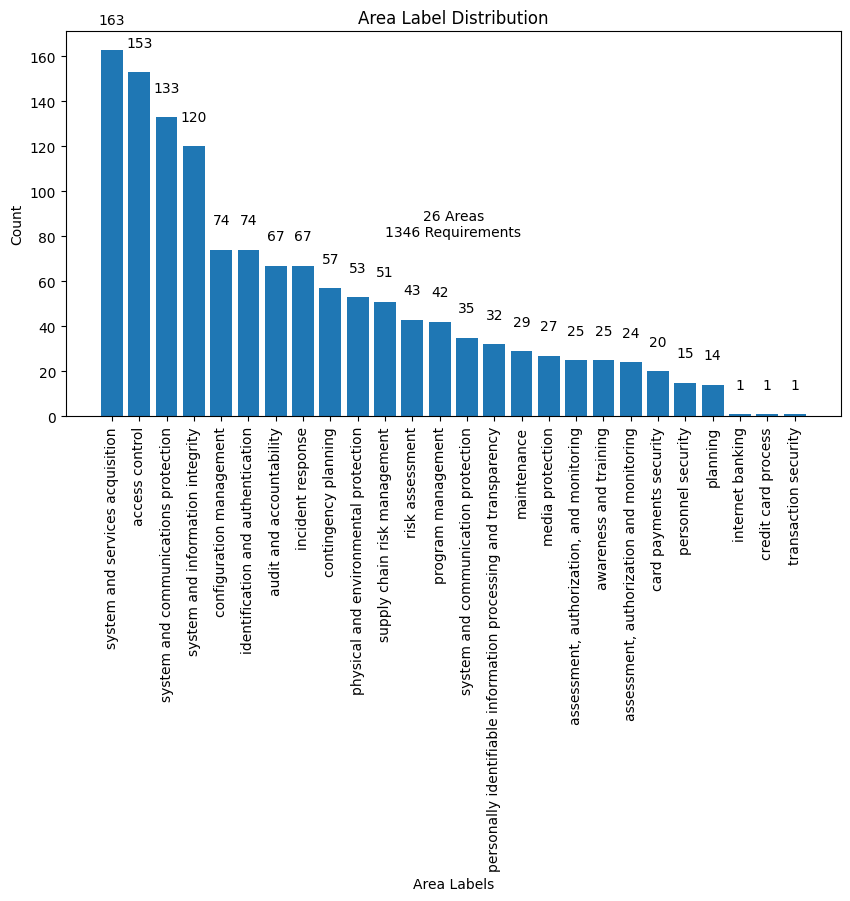

In [ ]:
# Visualize label distribution for 'Area'
import matplotlib.pyplot as plt

# Get the sorted area labels and their counts
area_labels, area_counts = zip(*sorted(zip(train_df['Requirement Area (NIST)'].value_counts().index, train_df['Requirement Area (NIST)'].value_counts()), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(10, 5))
plt.bar(area_labels, area_counts)
plt.xticks(rotation=90)

# add title with the number of areas and the total number of requirements
plt.title('Area Label Distribution')
plt.text(0.5, 0.5, str(len(area_labels)) + ' Areas\n' + str(len(train_df)) + ' Requirements',
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.xlabel('Area Labels')
plt.ylabel('Count')
#PRINT COUNT OF EACH AREA
for i, v in enumerate(area_counts):
    print(area_labels[i], v)
   
# add count values on top of the bars
for i, v in enumerate(area_counts):
    plt.text(i, v + 10, str(v), ha='center', va='bottom')

plt.show()


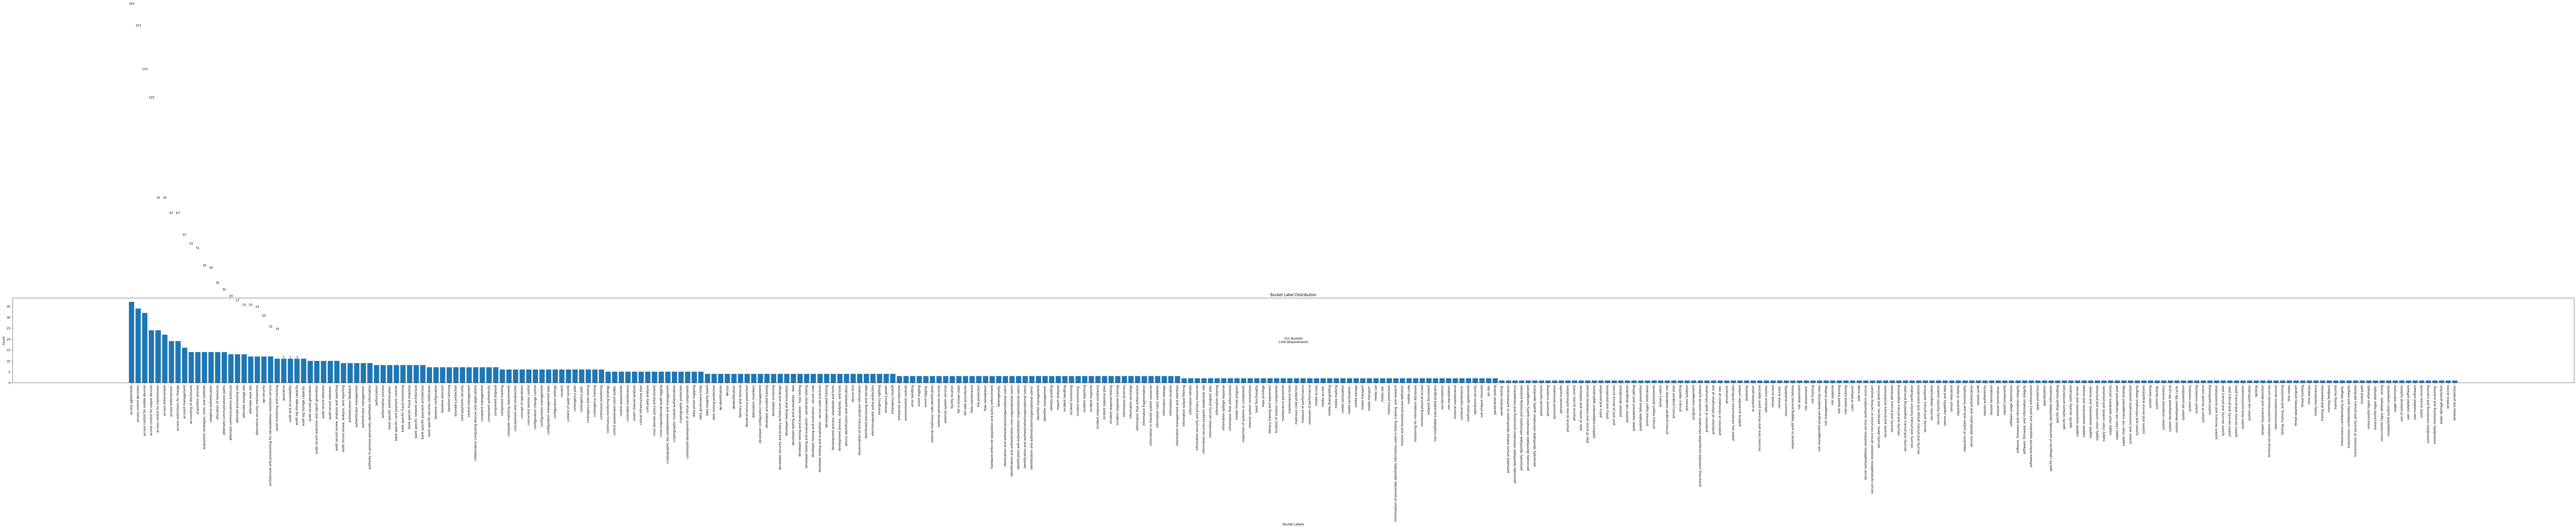

In [ ]:

# Cell 15
# Visualize label distribution for 'Bucket'
plt.figure(figsize=(150, 5))
#start from 0 to 150
plt.bar(bucket_encoder.classes_, train_df['Requirement Bucket(NIST)'].value_counts())
#rotate the labels by 90 degrees
plt.xticks(rotation=90)
#add title with no.of buckets and total no.of requirements
plt.title('Bucket Label Distribution')
plt.text(0.5, 0.5, str(len(bucket_encoder.classes_)) + ' Buckets\n' + str(len(train_df)) + ' Requirements',
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
#label the x and y axis
plt.xlabel('Bucket Labels')
plt.ylabel('Count')
#display the count of each label
# add count values on top of the bars
for i, v in enumerate(area_counts):
    plt.text(i, v + 10, str(v), ha='center', va='bottom')



plt.show()

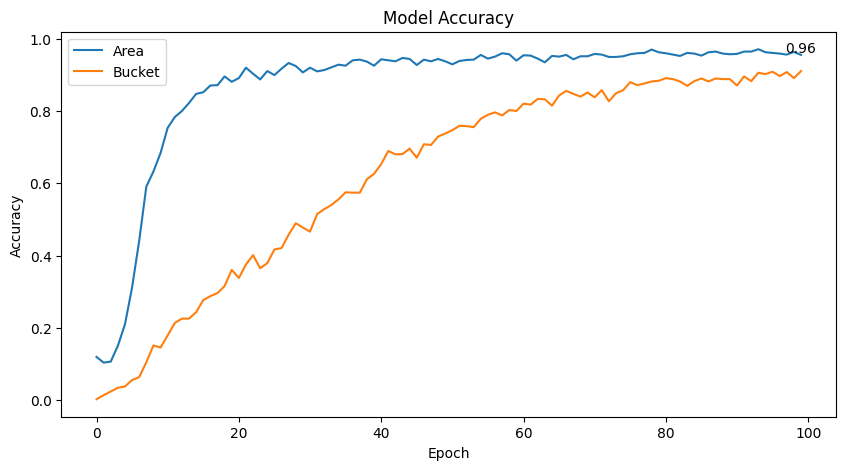

In [ ]:
# Cell 16
# Visualize training history for 'Area' and 'Bucket'
plt.figure(figsize=(10, 5))
plt.plot(history.history['output_area_accuracy'])
plt.plot(history.history['output_bucket_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Area', 'Bucket'], loc='upper left')
# add highest accuracy values on top of the lines
plt.text(len(history.history['output_area_accuracy']) - 1, history.history['output_area_accuracy'][-1],
         str(round(history.history['output_area_accuracy'][-1], 2)), ha='center', va='bottom')
plt.show()
